### Saving image dataset and labels as npy

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 


C:\Users\ferreira\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ferreira\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\ferreira\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
ls = ["AMdst", "BMdst", "MCcSt", "MCSt"]
for i in ls:    
    print(len(os.listdir(i)))

<IPython.core.display.Javascript object>

83


<IPython.core.display.Javascript object>

154


<IPython.core.display.Javascript object>

124


<IPython.core.display.Javascript object>

152


In [3]:
from PIL import Image
from numpy import asarray
# load the image
image = Image.open('MCcSt/sample_4_10X_PP_2.jpg')
# convert image to numpy array
data = asarray(image)
print(type(data))
# summarize shape
print(data.shape)

<class 'numpy.ndarray'>
(484, 646, 3)


In [4]:
dct = {"AMdst":0, "BMdst":1, "MCcSt":2, "MCSt":3}


### Load npy generated by 00-preprocessing.ipynb

In [6]:
train_imgs = np.load("train_imgs.npy")
train_labels = np.load("train_labels.npy")
test_imgs = np.load("test_imgs.npy")
test_labels = np.load("test_labels.npy")

### Vision Transformers for image classification

In [7]:
(x_train, y_train), (x_test, y_test) = (train_imgs, train_labels), (test_imgs, test_labels)
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (410, 484, 646, 3) - y_train shape: (410,)
x_test shape: (103, 484, 646, 3) - y_test shape: (103,)


In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [9]:
num_classes = 4
input_shape = (484, 646, 3)

In [10]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 16
num_epochs = 100
image_size = 144  # We'll resize input images to this size
patch_size = 24  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [11]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.Resizing(image_size, image_size),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


In [12]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


In [13]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Image size: 144 X 144
Patch size: 24 X 24
Patches per image: 36
Elements per patch: 1728


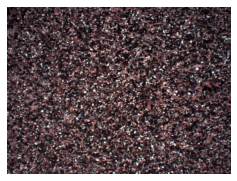

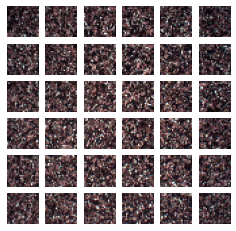

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [48]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [49]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [50]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

#     checkpoint_filepath = "/tmp/checkpoint"
#     checkpoint_callback = keras.callbacks.ModelCheckpoint(
#         checkpoint_filepath,
#         monitor="val_accuracy",
#         save_best_only=True,
#         save_weights_only=True,
#     )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.2,
        #callbacks=[checkpoint_callback],
    )

#     model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/100
21/21 [==============================] - 11s 144ms/step - loss: 3.0224 - accuracy: 0.3657 - top-5-accuracy: 1.0000 - val_loss: 3.1228 - val_accuracy: 0.3537 - val_top-5-accuracy: 1.0000
Epoch 2/100
21/21 [==============================] - 2s 79ms/step - loss: 3.8050 - accuracy: 0.4281 - top-5-accuracy: 1.0000 - val_loss: 1.9485 - val_accuracy: 0.5244 - val_top-5-accuracy: 1.0000
Epoch 

Epoch 80/100
21/21 [==============================] - 2s 77ms/step - loss: 0.3504 - accuracy: 0.8667 - top-5-accuracy: 1.0000 - val_loss: 0.8592 - val_accuracy: 0.7195 - val_top-5-accuracy: 1.0000
Epoch 81/100
21/21 [==============================] - 2s 77ms/step - loss: 0.2759 - accuracy: 0.9030 - top-5-accuracy: 1.0000 - val_loss: 1.0467 - val_accuracy: 0.6707 - val_top-5-accuracy: 1.0000
Epoch 82/100
21/21 [==============================] - 2s 77ms/step - loss: 0.3987 - accuracy: 0.8524 - top-5-accuracy: 1.0000 - val_loss: 0.9893 - val_accuracy: 0.6707 - val_top-5-accuracy: 1.0000
Epoch 83/100
21/21 [==============================] - 2s 76ms/step - loss: 0.5024 - accuracy: 0.7951 - top-5-accuracy: 1.0000 - val_loss: 1.2806 - val_accuracy: 0.5854 - val_top-5-accuracy: 1.0000
Epoch 84/100
21/21 [==============================] - 2s 78ms/step - loss: 0.6301 - accuracy: 0.7566 - top-5-accuracy: 1.0000 - val_loss: 0.8329 - val_accuracy: 0.7317 - val_top-5-accuracy: 1.0000
Epoch 85/100
21

### Accuracy model trained with 24x24 patches in 144x144 image

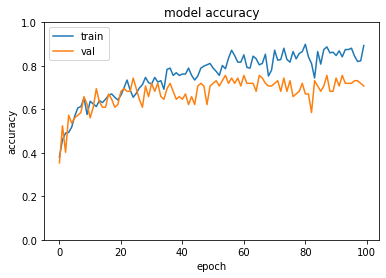

In [51]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0,1.0)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Loss model trained with 24x24 patches in 144x144 image

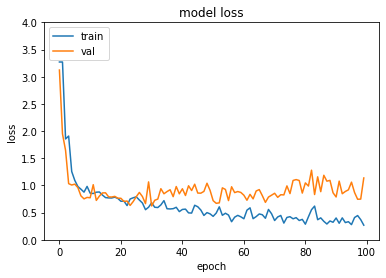

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim(0,4.0)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Accuracy model trained with 12x12 patches in 72x72 images

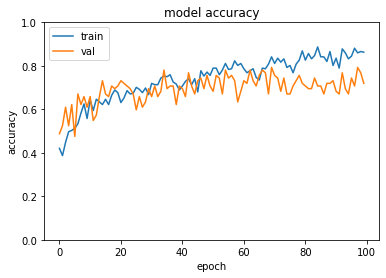

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0,1.0)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Accuracy model trained with 6x6 patches

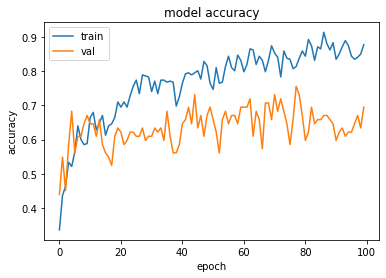

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0,1.0)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Loss model trained with 12x12 patches

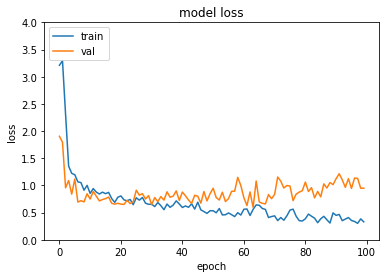

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim(0,4.0)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Loss model trained with 6x6 patches

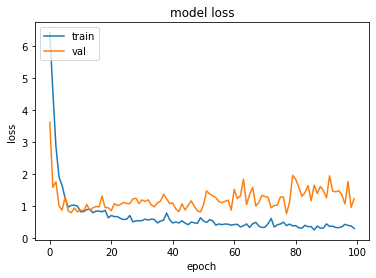

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim(0,4.0)
plt.legend(['train', 'val'], loc='upper left')
plt.show()